
# Módulo de productividad de pozos

Analisis estadístico y simulación de gasto de aceite en base a producción histórica en México. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

import timeit

In [2]:
pd.set_option('display.max_rows', 100_000_000)
pd.set_option('display.max_columns', 100_000_000)
pd.set_option('display.width', 1_000)
pd.set_option('precision', 2)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
import timeit
tic=timeit.default_timer()
toc=timeit.default_timer()
toc - tic #elapsed time in seconds

4.625500000088323e-05

<div class="alert alert-block alert-danger">

### <b>Check Harmonic Equation</b>
<br>
· b should be = 1, check bounds argument in harmonic_equation
<br>
· automate unique_well_list generation
<br>

</div>

In [4]:
def input_pozos(x): 
        
        global pozos
        pozos = pd.DataFrame(columns=["Campo",
                                      "Coordenadas",
                                      "Qo aceite",
                                      "Qo gas"])

        #parts=int(input("Numero de campos: "))
        parts = x

        # !!!!!! Verificar resultado de la funcion format... cambiar a integer
        
        for i in range(parts):
            campo = input("Nombre de Campo: ")
            coordenadas = input("Coordenadas: ".format(campo))
            Qo_aceite = input("Qo aceite: ".format(campo))
            Qo_gas = input("Qo gas: ".format(campo))
            df1 = pd.DataFrame(data=[[campo,coordenadas,Qo_aceite,Qo_gas]],columns=["Campo",
                                                                                    "Coordenadas",
                                                                                    "Qo aceite",
                                                                                    "Qo gas"])
            pozos = pd.concat([pozos,df1], axis=0)

        pozos.index = range(len(pozos.index))

## Estadistica - Kumaza

Unnamed: 0       fecha campo yacimiento plataforma   pozo inicio_produccion_aceite ultima_produccion_aceite  gasto_aceite_Mbd  gasto_agua_Mbd  gasto_gas_MMpcd  gasto_gas_BN_MMpcd  RGA_m3/m3  aceite_acumulado_MMb  agua_acumulada_MMb  gas_acumulado_MMMpc  cima_intervalo_mvbnm  base_intervalo_mvbnm distancia_superior_intervalo_a_contacto_gas-aceite_(m) fluyente_BEC_o _BN  RGA_pc/bl    nivel_CGA cima_mv -nivel_CGA   estatus arriba_abajo_CGA campo_yacimiento   first_oil  Dias Produciendo  days_online  Exponential_Predicted  Hyperbolic_Predicted  Harmonic_Predicted
0           0  2016-01-31    KU     KU_CCE       KU-A  KU-10                 02/28/86                 31/01/16              1.22            0.01             2.30                1.79        nan                  9.93                0.13                 5.87              2,585.00              2,603.00                                                  -                     BN   1,889.96       2919.2             -334.2  OPERANDO           ARRIBA     Ku-Crétacico  2016-01-31                 0            0                   1.22                  0.60                0.61
1         178  2016-02-29    KU     KU_CCE       KU-A  KU-10                 02/28/86                 29/02/16              0.15            0.01             0.28                0.40     331.05                  9.93                0.13                 5.87              2,585.00              2,603.00                                                  -                     BN   1,858.69  2924.518217        -339.518217  OPERANDO           ARRIBA     Ku-Crétacico  2016-01-31                29           29                   0.00                  0.60                0.60
2         357  2016-03-31    KU     KU_CCE       KU-A  KU-10                 02/28/86                 31/03/16              0.44            0.10             0.90                2.05     367.06                  9.94                0.14                 5.90              2,585.00              2,603.00                                                  -                     BN   2,060.87       2918.6             -333.6  OPERANDO           ARRIBA     Ku-Crétacico  2016-01-31                60           60                   0.00                  0.59                0.59
3         538  2016-04-30    KU     KU_CCE       KU-A  KU-10                 02/28/86                 30/04/16              0.44            0.03             0.97                1.81     389.10                  9.96                0.14                 5.93              2,585.00              2,603.00                                                  -                     BN   2,184.62       2918.6             -333.6  OPERANDO           ARRIBA     Ku-Crétacico  2016-01-31                90           90                   0.00                  0.59                0.59
4         719  2016-05-31    KU     KU_CCE       KU-A  KU-10                 02/28/86                 31/05/16              0.45            0.07             0.98                2.61     388.96                  9.97                0.14                 5.96              2,585.00              2,603.00                                                  -                     BN   2,183.85       2923.5             -338.5  OPERANDO           ARRIBA     Ku-Crétacico  2016-01-31               121          121                   0.00                  0.58                0.58

Index(['Unnamed: 0', 'fecha', 'campo', 'yacimiento', 'plataforma', 'pozo', 'inicio_produccion_aceite', 'ultima_produccion_aceite', 'gasto_aceite_Mbd', 'gasto_agua_Mbd', 'gasto_gas_MMpcd', 'gasto_gas_BN_MMpcd', 'RGA_m3/m3', 'aceite_acumulado_MMb', 'agua_acumulada_MMb', 'gas_acumulado_MMMpc', 'cima_intervalo_mvbnm', 'base_intervalo_mvbnm', 'distancia_superior_intervalo_a_contacto_gas-aceite_(m)', 'fluyente_BEC_o _BN', 'RGA_pc/bl', 'nivel_CGA', 'cima_mv -nivel_CGA', 'estatus', 'arriba_abajo_CGA', 'campo_yacimiento', 'first_oil', 'Dias Produciendo', 'days_online', 'Exponential_Predicted', 'Hyperbolic_Predicted', 'Harmonic_Predicted'], dtype='object')

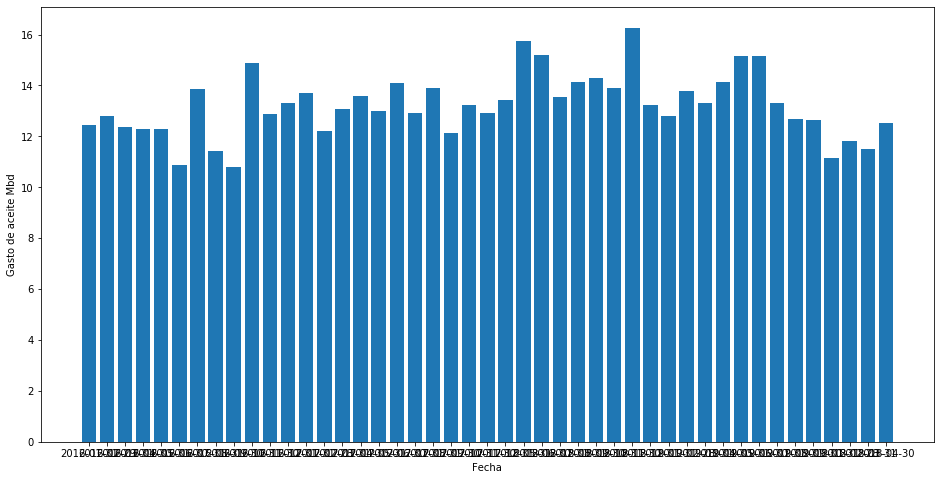

In [5]:
df=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/kumaza_dca.csv',
               parse_dates=True)
display(df.head(),df.columns)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(df.fecha,df.gasto_aceite_Mbd)
ax.set_xlabel('Fecha')
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()
#df.gasto_gas_MMpcd.plot(figsize=(20,10),cmap='viridis')

## Dispersion Analysis

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


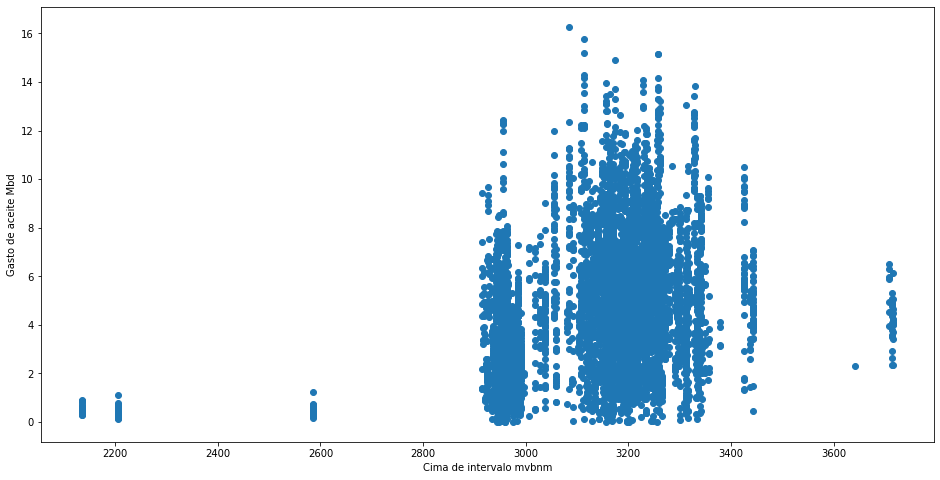

In [6]:
%time 

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['cima_intervalo_mvbnm'],df['gasto_aceite_Mbd'])
ax.set_xlabel('Cima de intervalo mvbnm')
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


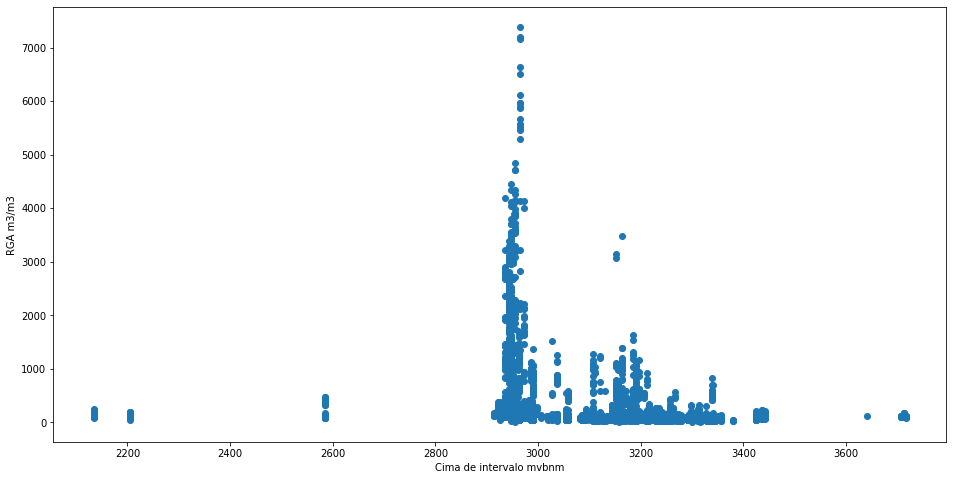

In [7]:
%time 

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['cima_intervalo_mvbnm'],df['RGA_m3/m3'] )
ax.set_xlabel('Cima de intervalo mvbnm')
ax.set_ylabel('RGA m3/m3')
plt.show()

In [8]:
df.columns

Index(['Unnamed: 0', 'fecha', 'campo', 'yacimiento', 'plataforma', 'pozo', 'inicio_produccion_aceite', 'ultima_produccion_aceite', 'gasto_aceite_Mbd', 'gasto_agua_Mbd', 'gasto_gas_MMpcd', 'gasto_gas_BN_MMpcd', 'RGA_m3/m3', 'aceite_acumulado_MMb', 'agua_acumulada_MMb', 'gas_acumulado_MMMpc', 'cima_intervalo_mvbnm', 'base_intervalo_mvbnm', 'distancia_superior_intervalo_a_contacto_gas-aceite_(m)', 'fluyente_BEC_o _BN', 'RGA_pc/bl', 'nivel_CGA', 'cima_mv -nivel_CGA', 'estatus', 'arriba_abajo_CGA', 'campo_yacimiento', 'first_oil', 'Dias Produciendo', 'days_online', 'Exponential_Predicted', 'Hyperbolic_Predicted', 'Harmonic_Predicted'], dtype='object')

In [9]:
to_plot=pd.DataFrame(df,columns=['fecha', 
                                 'campo',
                                 'pozo', 
                                 'gasto_aceite_Mbd',
                                 'gasto_agua_Mbd',
                                 'gasto_gas_MMpcd',
                                 'gasto_gas_BN_MMpcd',
                                 'RGA_m3/m3',
                                 'aceite_acumulado_MMb', 
                                 'agua_acumulada_MMb',
                                 'gas_acumulado_MMMpc',
                                 'cima_intervalo_mvbnm',
                                 'base_intervalo_mvbnm',
                                 'days_online', 
                                 'Exponential_Predicted', 
                                 'Hyperbolic_Predicted', 
                                 'Harmonic_Predicted'])

In [10]:
to_plot2=pd.DataFrame(df,columns=['fecha', 
                                 'campo',
                                 'pozo', 
                                 'gasto_aceite_Mbd',
                                 'gasto_agua_Mbd',
                                 'gasto_gas_MMpcd',
                                 'gasto_gas_BN_MMpcd',
                                 'days_online',
                                 'RGA_m3/m3',])

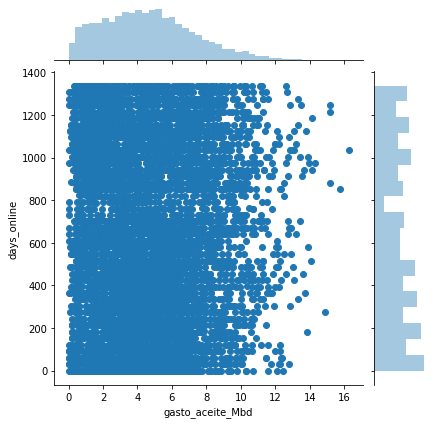

In [11]:
sns.jointplot(to_plot2.gasto_aceite_Mbd,to_plot2.days_online)

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


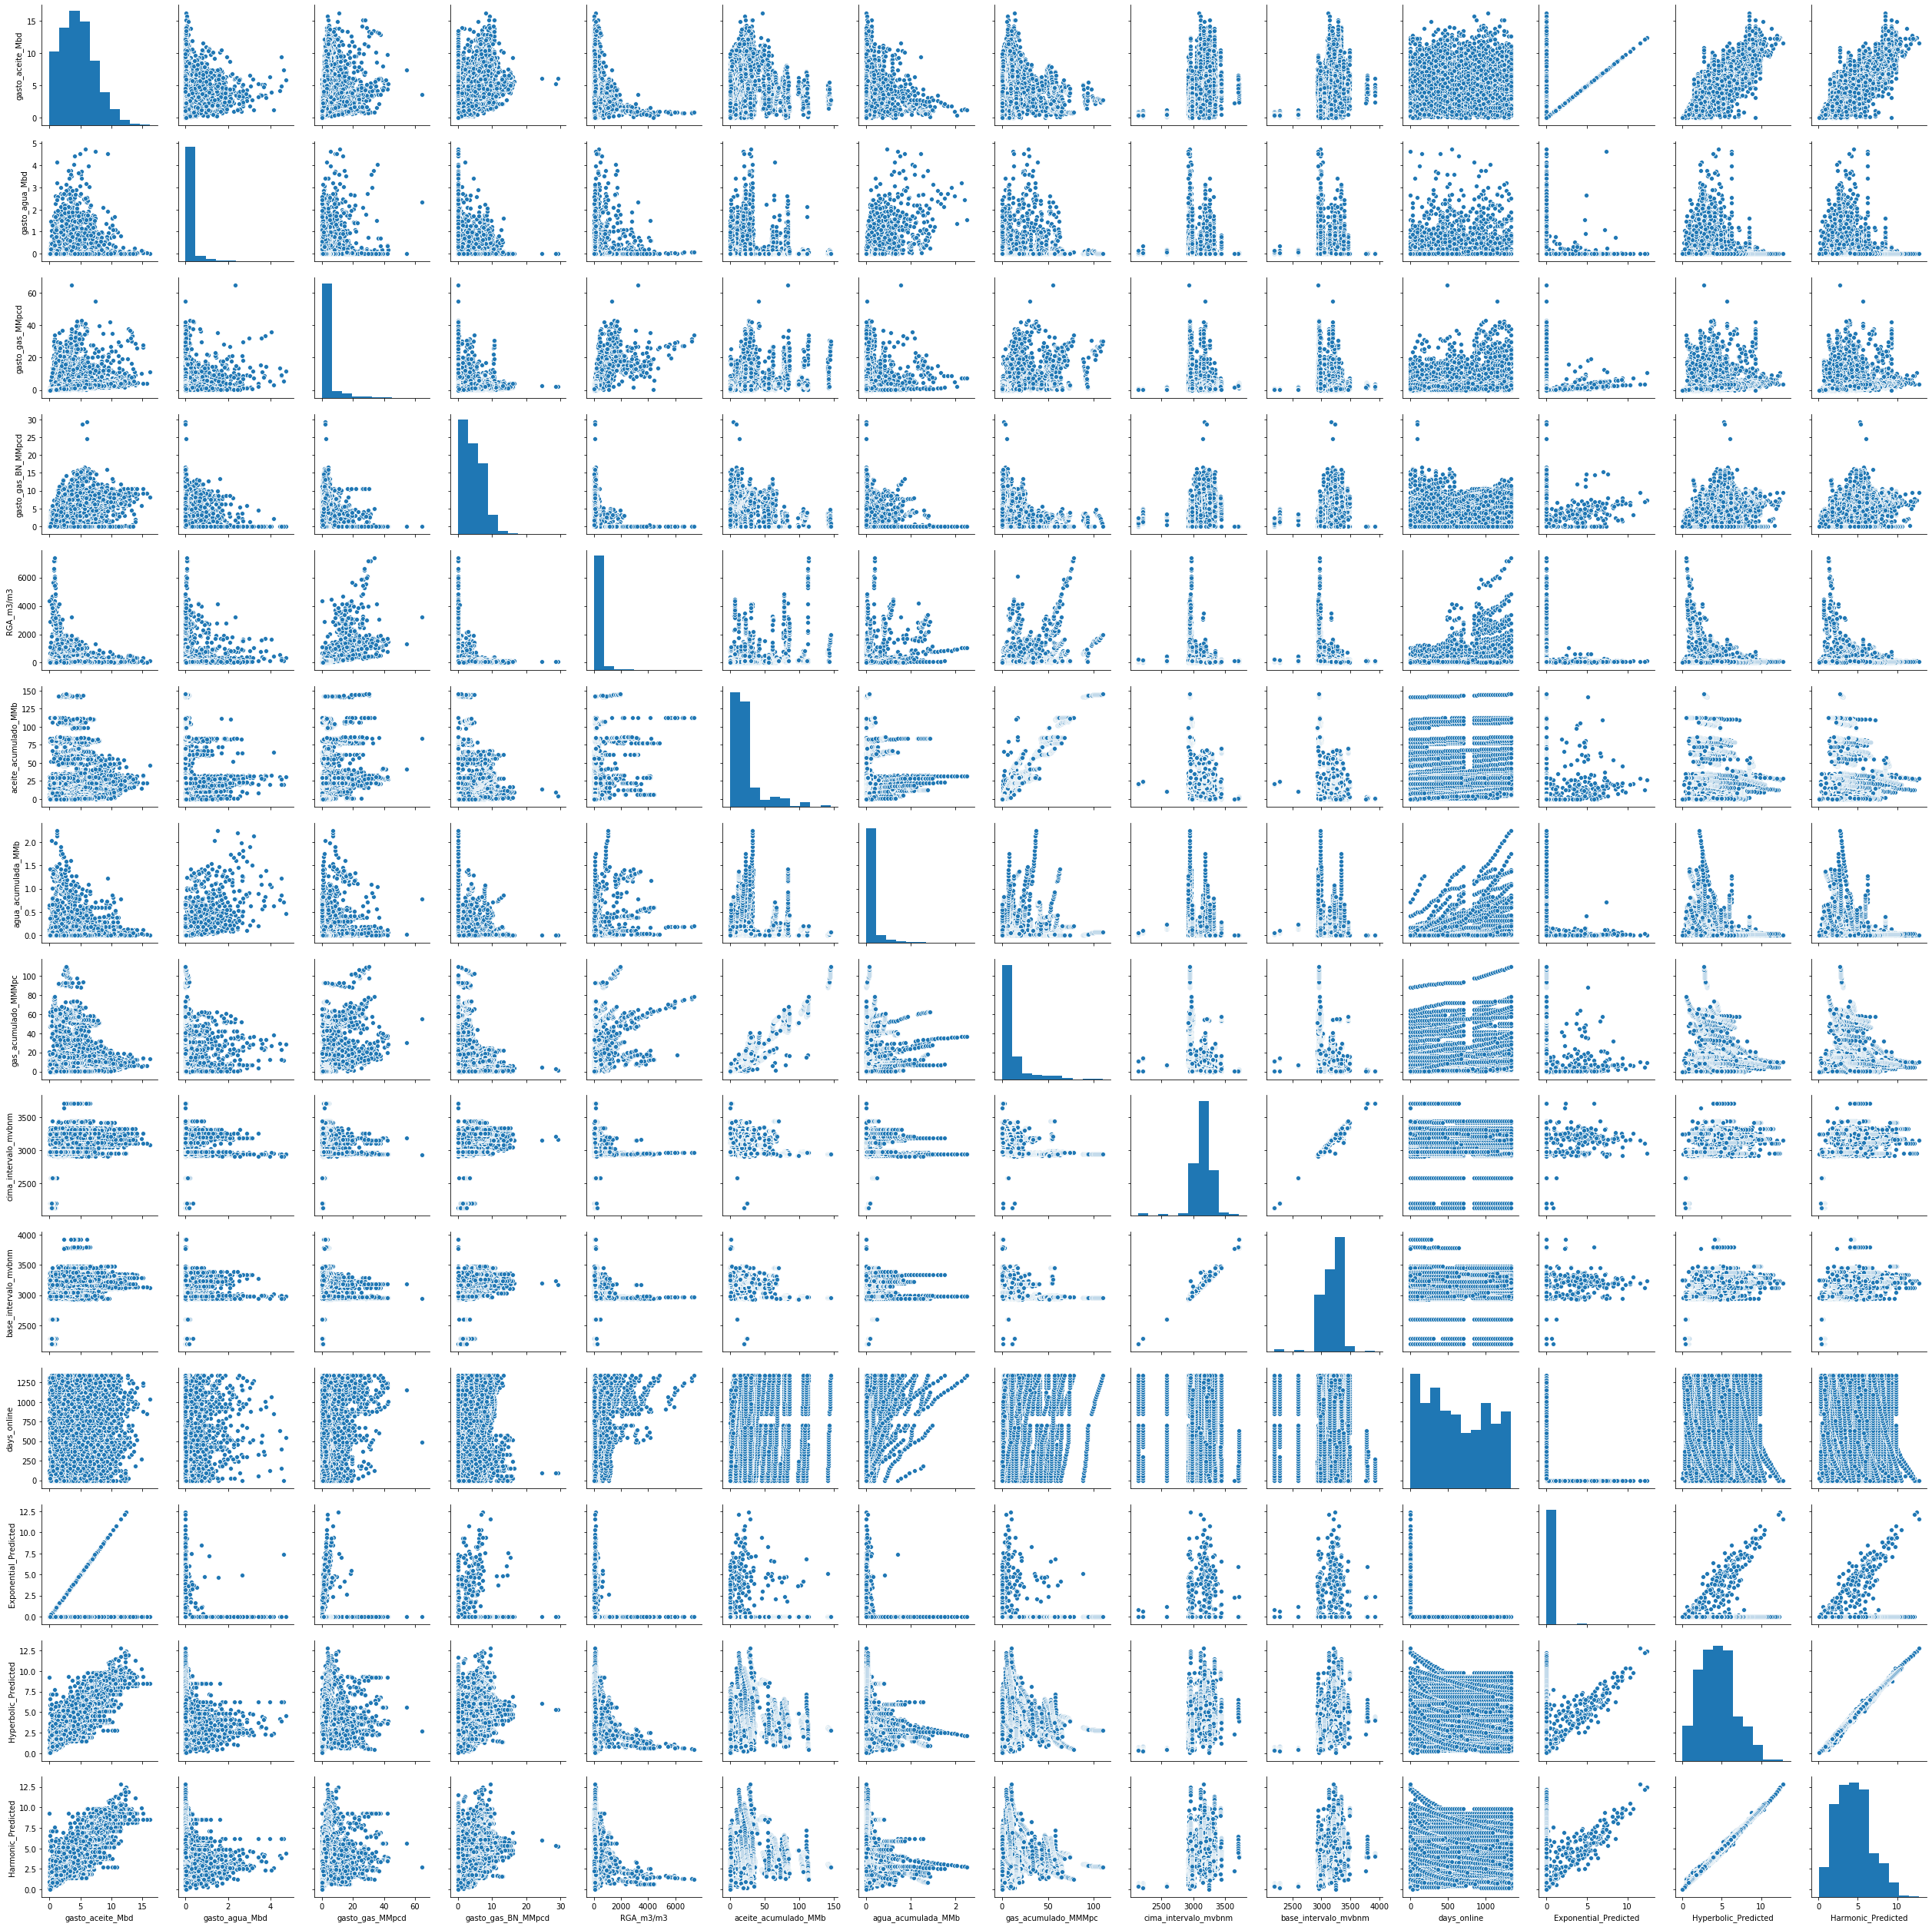

In [12]:
sns.pairplot(to_plot)

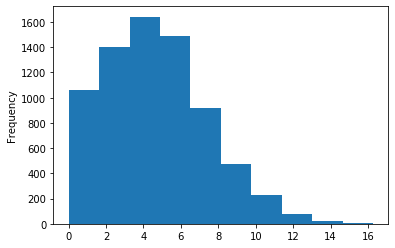

In [13]:
df.gasto_aceite_Mbd.plot.hist()

In [14]:
display(df.head(),df.shape)
unique_well_list=pd.unique(list(df.pozo))
display(unique_well_list.shape, len(unique_well_list))

Unnamed: 0       fecha campo yacimiento plataforma   pozo inicio_produccion_aceite ultima_produccion_aceite  gasto_aceite_Mbd  gasto_agua_Mbd  gasto_gas_MMpcd  gasto_gas_BN_MMpcd  RGA_m3/m3  aceite_acumulado_MMb  agua_acumulada_MMb  gas_acumulado_MMMpc  cima_intervalo_mvbnm  base_intervalo_mvbnm distancia_superior_intervalo_a_contacto_gas-aceite_(m) fluyente_BEC_o _BN  RGA_pc/bl    nivel_CGA cima_mv -nivel_CGA   estatus arriba_abajo_CGA campo_yacimiento   first_oil  Dias Produciendo  days_online  Exponential_Predicted  Hyperbolic_Predicted  Harmonic_Predicted
0           0  2016-01-31    KU     KU_CCE       KU-A  KU-10                 02/28/86                 31/01/16              1.22            0.01             2.30                1.79        nan                  9.93                0.13                 5.87              2,585.00              2,603.00                                                  -                     BN   1,889.96       2919.2             -334.2  OPERANDO           ARRIBA     Ku-Crétacico  2016-01-31                 0            0                   1.22                  0.60                0.61
1         178  2016-02-29    KU     KU_CCE       KU-A  KU-10                 02/28/86                 29/02/16              0.15            0.01             0.28                0.40     331.05                  9.93                0.13                 5.87              2,585.00              2,603.00                                                  -                     BN   1,858.69  2924.518217        -339.518217  OPERANDO           ARRIBA     Ku-Crétacico  2016-01-31                29           29                   0.00                  0.60                0.60
2         357  2016-03-31    KU     KU_CCE       KU-A  KU-10                 02/28/86                 31/03/16              0.44            0.10             0.90                2.05     367.06                  9.94                0.14                 5.90              2,585.00              2,603.00                                                  -                     BN   2,060.87       2918.6             -333.6  OPERANDO           ARRIBA     Ku-Crétacico  2016-01-31                60           60                   0.00                  0.59                0.59
3         538  2016-04-30    KU     KU_CCE       KU-A  KU-10                 02/28/86                 30/04/16              0.44            0.03             0.97                1.81     389.10                  9.96                0.14                 5.93              2,585.00              2,603.00                                                  -                     BN   2,184.62       2918.6             -333.6  OPERANDO           ARRIBA     Ku-Crétacico  2016-01-31                90           90                   0.00                  0.59                0.59
4         719  2016-05-31    KU     KU_CCE       KU-A  KU-10                 02/28/86                 31/05/16              0.45            0.07             0.98                2.61     388.96                  9.97                0.14                 5.96              2,585.00              2,603.00                                                  -                     BN   2,183.85       2923.5             -338.5  OPERANDO           ARRIBA     Ku-Crétacico  2016-01-31               121          121                   0.00                  0.58                0.58

(7328, 32)

(222,)

222

count   7,328.00
mean        4.66
std         2.72
min         0.00
25%         2.57
50%         4.46
75%         6.37
max        16.27
Name: gasto_aceite_Mbd, dtype: float64

0.10   1.20
0.50   4.46
0.90   8.36
Name: gasto_aceite_Mbd, dtype: float64

count   7,328.00
mean        4.45
std         2.23
min         0.03
25%         2.77
50%         4.30
75%         5.74
max        12.80
Name: Hyperbolic_Predicted, dtype: float64

0.10   1.70
0.50   4.30
0.90   7.53
Name: Hyperbolic_Predicted, dtype: float64

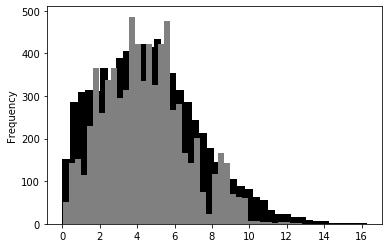

In [15]:
display(df.gasto_aceite_Mbd.describe(),
        df.gasto_aceite_Mbd.quantile([.1,.5,.9]),
        df.Hyperbolic_Predicted.describe(),
        df.Hyperbolic_Predicted.quantile([.1,.5,.9]))
df.gasto_aceite_Mbd.plot.hist(bins=40,color='black'),
df.Hyperbolic_Predicted.plot.hist(bins=40,color='gray')

count   7,328.00
mean        3.66
std         5.25
min         0.00
25%         1.24
50%         2.12
75%         3.52
max        64.57
Name: gasto_gas_MMpcd, dtype: float64

0.10   0.65
0.50   2.12
0.90   7.48
Name: gasto_gas_MMpcd, dtype: float64

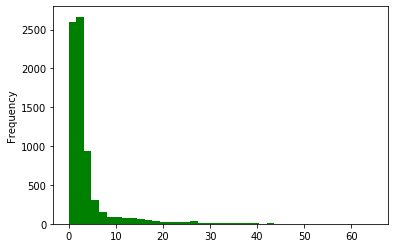

In [16]:
display(df.gasto_gas_MMpcd.describe(),
       df.gasto_gas_MMpcd.quantile([.1,.5,.9]))
df.gasto_gas_MMpcd.plot.hist(bins=40,color='green')

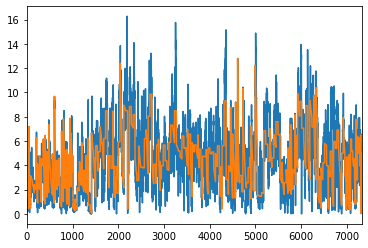

In [17]:
df.gasto_aceite_Mbd.plot()
df.Hyperbolic_Predicted.plot()

In [18]:
class Distribution(object):
    
    def __init__(self,dist_names_list = []):
        self.dist_names = ['beta',
                            'expon',
                            'gamma',
                            'lognorm',
                            'norm',
                            'pearson3',
                            'triang',
                            'uniform',
                            'weibull_min', 
                            'weibull_max']
        self.dist_results = []
        self.params = {}
        
        self.DistributionName = ""
        self.PValue = 0
        self.Param = None
        
        self.isFitted = False
        
        
    def Fit(self, y):
        self.dist_results = []
        self.params = {}
        for dist_name in self.dist_names:
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            
            self.params[dist_name] = param
            #Applying the Kolmogorov-Smirnov test
            D, p = scipy.stats.kstest(y, dist_name, args=param);
            self.dist_results.append((dist_name,p))
        #select the best fitted distribution
        sel_dist,p = (max(self.dist_results,key=lambda item:item[1]))
        #store the name of the best fit and its p value
        self.DistributionName = sel_dist
        self.PValue = p
        
        self.isFitted = True
        return self.DistributionName,self.PValue
    
    def Random(self, n = 1):
        if self.isFitted:
            dist_name = self.DistributionName
            param = self.params[dist_name]
            #initiate the scipy distribution
            dist = getattr(scipy.stats, dist_name)
            return dist.rvs(*param[:-2], loc=param[-2], scale=param[-1], size=n)
        else:
            raise ValueError('Must first run the Fit method.')
            
    def Plot(self,y):
        x = self.Random(n=len(y))
        fig, ax = plt.subplots(figsize=(16,8))
        plt.hist(x, alpha=0.5, label='Fitted',bins=50)
        plt.hist(y, alpha=0.5, label='Actual',bins=50)
        plt.legend(loc='upper right')

# Estadística CAMPOS

In [19]:
import timeit
tic=timeit.default_timer()

mx_stats=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/pozos/mx_benchmark.csv',
                    low_memory=False)

display(mx_stats.shape)

toc=timeit.default_timer()
toc - tic #elapsed time in seconds

(2838332, 10)

3.6432025400000043

In [20]:
input_campo = input("Nombre de Campo: ")

Nombre de Campo: POZA RICA


In [21]:
import timeit
tic=timeit.default_timer()

selected_rows=mx_stats.pozo.str.contains(str(input_campo))
campo=mx_stats.loc[selected_rows]

unique_well_list=pd.unique(campo['pozo'])

display('Número de pozos en:',
        input_campo,
        len(unique_well_list),
        unique_well_list,
        campo.shape)


toc=timeit.default_timer()
toc - tic #elapsed time in seconds

'Número de pozos en:'

'POZA RICA'

356

array(['POZA RICA-103', 'POZA RICA-170', 'POZA RICA-188', 'POZA RICA-197',
       'POZA RICA-198', 'POZA RICA-199', 'POZA RICA-200', 'POZA RICA-204',
       'POZA RICA-221', 'POZA RICA-224', 'POZA RICA-243', 'POZA RICA-247',
       'POZA RICA-248', 'POZA RICA-26', 'POZA RICA-261', 'POZA RICA-266',
       'POZA RICA-291', 'POZA RICA-293', 'POZA RICA-294', 'POZA RICA-298',
       'POZA RICA-299', 'POZA RICA-302', 'POZA RICA-303', 'POZA RICA-306',
       'POZA RICA-308', 'POZA RICA-310', 'POZA RICA-311', 'POZA RICA-314',
       'POZA RICA-315', 'POZA RICA-320', 'POZA RICA-322', 'POZA RICA-324',
       'POZA RICA-327', 'POZA RICA-334', 'POZA RICA-341', 'POZA RICA-343',
       'POZA RICA-346', 'POZA RICA-348', 'POZA RICA-349', 'POZA RICA-350',
       'POZA RICA-352', 'POZA RICA-353', 'POZA RICA-355', 'POZA RICA-356',
       'POZA RICA-357', 'POZA RICA-358', 'POZA RICA-359', 'POZA RICA-360',
       'POZA RICA-361', 'POZA RICA-363', 'POZA RICA-368', 'POZA RICA-380',
       'POZA RICA-381', 'P

(90952, 10)

1.5282769380000332

In [22]:
import timeit
tic=timeit.default_timer()

display(campo.aceite_Mbd.quantile([.1,.5,.9]))
display(campo.describe())

toc=timeit.default_timer()
toc - tic #elapsed time in seconds

0.10   0.02
0.50   0.10
0.90   0.65
Name: aceite_Mbd, dtype: float64

Unnamed: 0  aceite_Mbd  agua_Mbd  condensado_Mbd  gas_asociado_MMpcd  gas_no_asociado_MMpcd
count   90,952.00   90,952.00 90,952.00       90,952.00           90,952.00              90,952.00
mean   289,094.28        0.29      0.11            0.00                0.02                   0.00
std    267,346.59        0.94      0.17            0.00                0.05                   0.00
min          0.00        0.00      0.00            0.00                0.00                   0.00
25%     79,698.75        0.04      0.01            0.00                0.00                   0.00
50%    196,137.50        0.10      0.04            0.00                0.00                   0.00
75%    448,753.25        0.25      0.14            0.00                0.02                   0.00
max    999,758.00      132.51      3.57            0.00                2.09                   0.18

0.0972829039999965

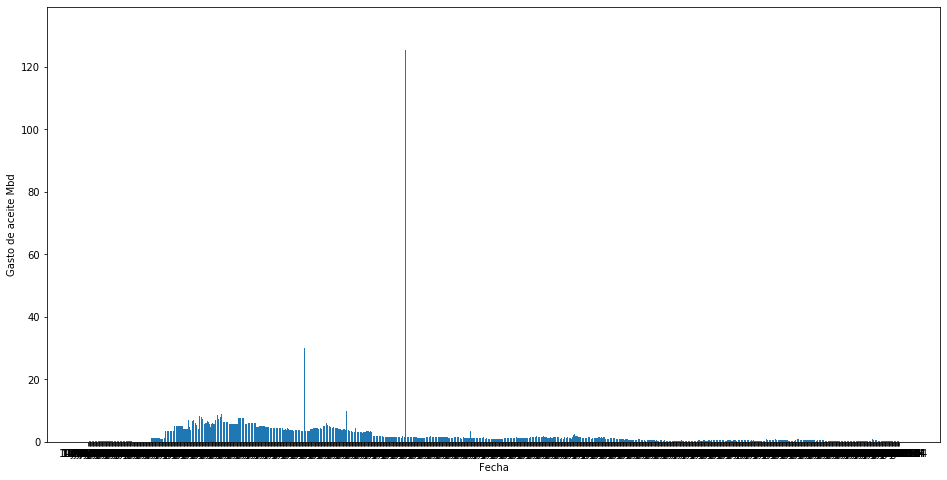

2465.953341145

In [23]:
import timeit
tic=timeit.default_timer()

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(campo.fecha,campo.aceite_Mbd)
ax.set_xlabel('Fecha')
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()

toc=timeit.default_timer()
toc - tic #elapsed time in seconds

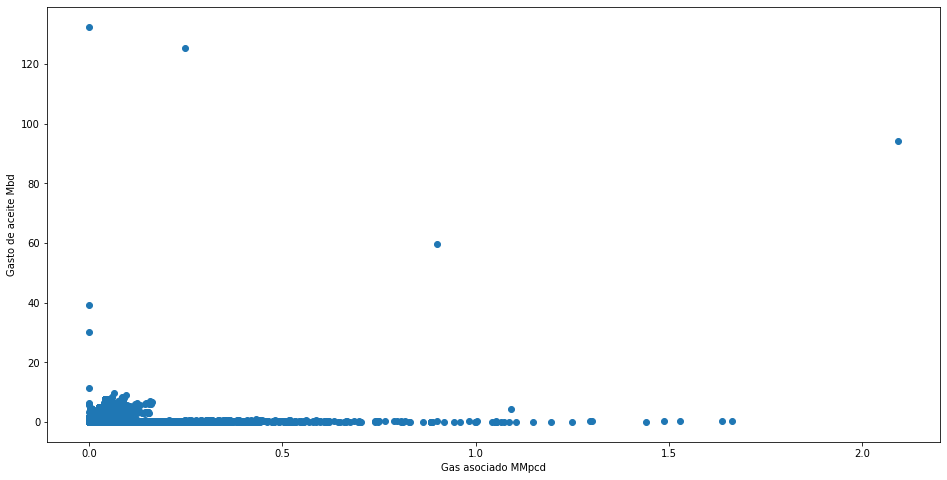

1.0921250650003458

In [24]:
import timeit
tic=timeit.default_timer()

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(campo.gas_asociado_MMpcd,campo.aceite_Mbd)
ax.set_xlabel('Gas asociado MMpcd')
ax.set_ylabel('Gasto de aceite Mbd')
plt.show()


toc=timeit.default_timer()
toc - tic #elapsed time in seconds

0.0695603949998258

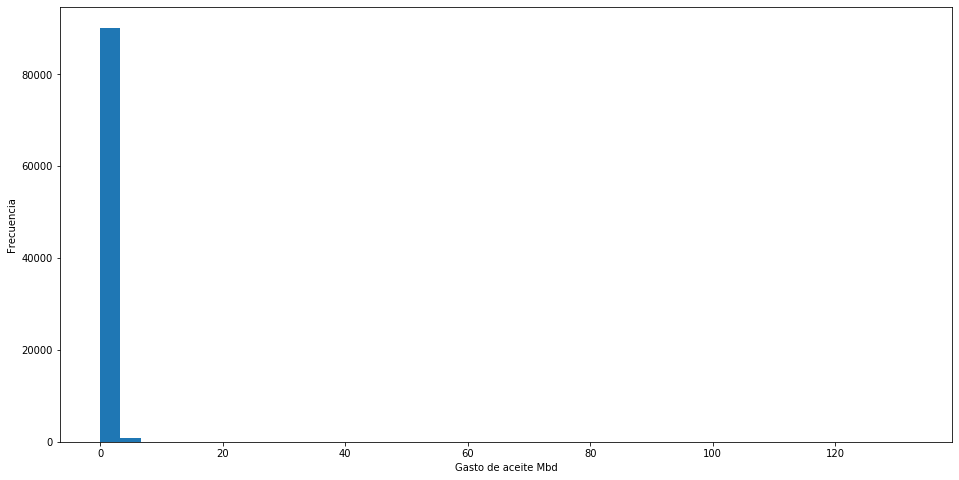

In [25]:
import timeit
tic=timeit.default_timer()

fig, ax = plt.subplots(figsize=(16,8))
ax.hist(campo.aceite_Mbd,
        bins=40,
        cumulative=False,
        density=False)
ax.set_xlabel('Gasto de aceite Mbd')
ax.set_ylabel('Frecuencia')

toc=timeit.default_timer()
toc - tic #elapsed time in seconds

/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


('lognorm', 3.1564064418837335e-46)

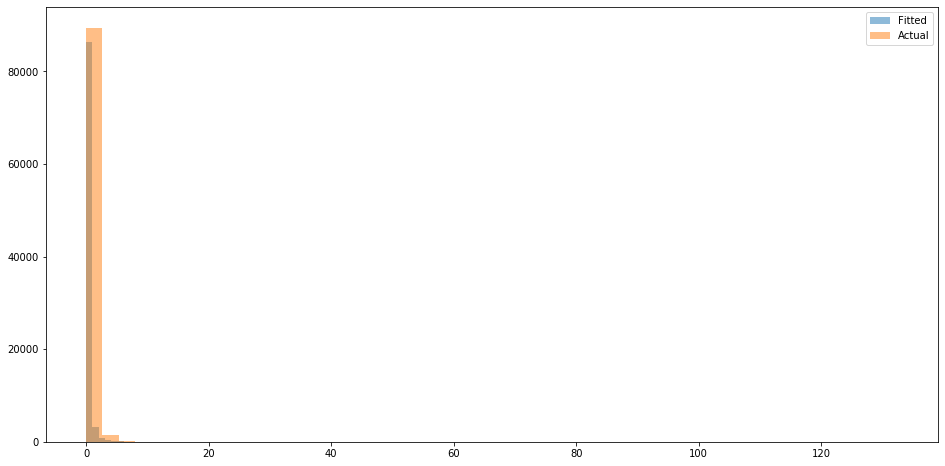

In [26]:
dst=Distribution()
display(dst.Fit(campo.aceite_Mbd))
dst.Plot(campo.aceite_Mbd)

## Q inicial

In [27]:
def get_max_initial_production(df, variable_column, well_column, date_column):
    global df_beginning_production
    global field
    """
    This function allows you to look at the first X months of production, and selects 
    the highest production month as max initial production
    Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
    """
    #First, sort the data frame from earliest to most recent prod date
    field=campo.sort_values(by=[date_column,well_column])
    num_months=int((len(field))*.20)
    #Pull out the first x months of production, where number_first_months is x
    df_beginning_production=field.head(num_months)
    #Return the max value in the selected variable column from the newly created 
    #df_beginning_production df
    return df_beginning_production[variable_column].max(), num_months, field.shape

In [28]:
get_max_initial_production(campo,'aceite_Mbd','pozo','fecha')

(132.50512, 18190, (90952, 10))

In [29]:
df_beginning_production.shape

(18190, 10)

In [30]:
for unique_well_list in field:
    display(get_max_initial_production)

<function __main__.get_max_initial_production(df, variable_column, well_column, date_column)>

<function __main__.get_max_initial_production(df, variable_column, well_column, date_column)>

<function __main__.get_max_initial_production(df, variable_column, well_column, date_column)>

<function __main__.get_max_initial_production(df, variable_column, well_column, date_column)>

<function __main__.get_max_initial_production(df, variable_column, well_column, date_column)>

<function __main__.get_max_initial_production(df, variable_column, well_column, date_column)>

<function __main__.get_max_initial_production(df, variable_column, well_column, date_column)>

<function __main__.get_max_initial_production(df, variable_column, well_column, date_column)>

<function __main__.get_max_initial_production(df, variable_column, well_column, date_column)>

<function __main__.get_max_initial_production(df, variable_column, well_column, date_column)>

# Función Estadística Campos

In [111]:
def estadistica_campo():
    global campo
    global unique_well_list
    global input_campo
    
    tic=timeit.default_timer()
    
    mx_stats=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/mexico/pozos/mx_benchmark.csv',
                        low_memory=False)
    
    display('Numero de datos en BD:'+str(len(mx_stats)))

    display(mx_stats.shape)
    
    input_campo = input("Nombre de Campo: ")
    
    selected_rows=mx_stats.pozo.str.contains(str(input_campo))
    campo=mx_stats.loc[selected_rows]

    display(campo.head(),campo.shape)
    
    unique_well_list=pd.unique(campo['pozo'])

    display('Número de pozos en:',
            input_campo,
            len(unique_well_list),
            unique_well_list,
            campo.shape)

    display(campo.aceite_Mbd.quantile([.1,.5,.9]),
            campo.describe())

    fig1, ax1 = plt.subplots(figsize=(16,8))
    mx_stats
    ax1.bar(campo.fecha,campo.aceite_Mbd)
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Gasto de aceite Mbd')
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(16,8))
    ax2.scatter(campo.fecha,campo.aceite_Mbd)
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Gasto de aceite Mbd')
    plt.show()

    fig3, ax3 = plt.subplots(figsize=(16,8))
    ax3.hist(campo.aceite_Mbd,
            bins=40,
            cumulative=False,
            density=False)
    ax3.set_xlabel('Gasto de aceite Mbd')
    ax3.set_ylabel('Frecuencia')
    

    dst=Distribution()
    display(dst.Fit(campo.aceite_Mbd))
    dst.Plot(campo.aceite_Mbd)
    
    campo.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+str('.csv'))
    
    toc=timeit.default_timer()
    toc - tic #elapsed time in seconds
    
    return toc - tic

'Numero de datos en BD:2838332'

(2838332, 10)

Nombre de Campo: ARENQUE


Unnamed: 0  aceite_Mbd  agua_Mbd asignacion  condensado_Mbd            cuenca       fecha  gas_asociado_MMpcd  gas_no_asociado_MMpcd         pozo
1629120        1366        0.65      0.06        NaN            0.00  Tampico-Misantla  1-Dec-2014                4.37                   0.00  ARENQUE-101
1629121        1367        0.06      0.00        NaN            0.00  Tampico-Misantla  1-Dec-2014                0.10                   0.00  ARENQUE-103
1629122        1368        0.20      0.08        NaN            0.00  Tampico-Misantla  1-Dec-2014                1.11                   0.00   ARENQUE-12
1629123        1369        0.73      0.07        NaN            0.00  Tampico-Misantla  1-Dec-2014                4.60                   0.00   ARENQUE-18
1629124        1370        0.32      1.09        NaN            0.00  Tampico-Misantla  1-Dec-2014                0.60                   0.00   ARENQUE-23

(9809, 10)

'Número de pozos en:'

'ARENQUE'

30

array(['ARENQUE-101', 'ARENQUE-103', 'ARENQUE-12', 'ARENQUE-18',
       'ARENQUE-23', 'ARENQUE-26', 'ARENQUE-30', 'ARENQUE-31',
       'ARENQUE-37', 'ARENQUE-41', 'ARENQUE-42', 'ARENQUE-46',
       'ARENQUE-58', 'ARENQUE-6', 'ARENQUE-24', 'ARENQUE-20',
       'ARENQUE-54', 'ARENQUE-5', 'ARENQUE-13A', 'ARENQUE-16',
       'ARENQUE-15', 'ARENQUE-22', 'ARENQUE-17', 'ARENQUE-10',
       'ARENQUE-28', 'ARENQUE-104', 'ARENQUE-48', 'ARENQUE-50',
       'ARENQUE-33', 'ARENQUE-56'], dtype=object)

(9809, 10)

0.10   0.08
0.50   0.30
0.90   1.08
Name: aceite_Mbd, dtype: float64

Unnamed: 0  aceite_Mbd  agua_Mbd  condensado_Mbd  gas_asociado_MMpcd  gas_no_asociado_MMpcd
count    9,809.00    9,809.00  9,809.00        9,809.00            9,809.00               9,809.00
mean   412,593.21        0.51      0.09            0.00                1.44                   0.00
std    237,992.65        0.64      0.16            0.00                1.63                   0.03
min      1,366.00        0.00      0.00            0.00                0.00                   0.00
25%    208,647.00        0.15      0.00            0.00                0.26                   0.00
50%    354,222.00        0.30      0.02            0.00                0.75                   0.00
75%    592,707.00        0.64      0.11            0.00                2.20                   0.00
max    997,317.00        6.59      1.28            0.00               10.63                   0.66

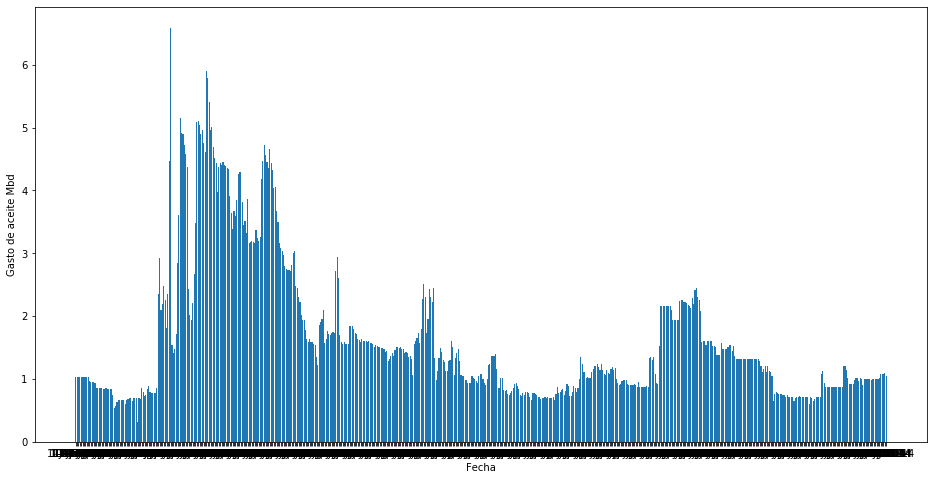

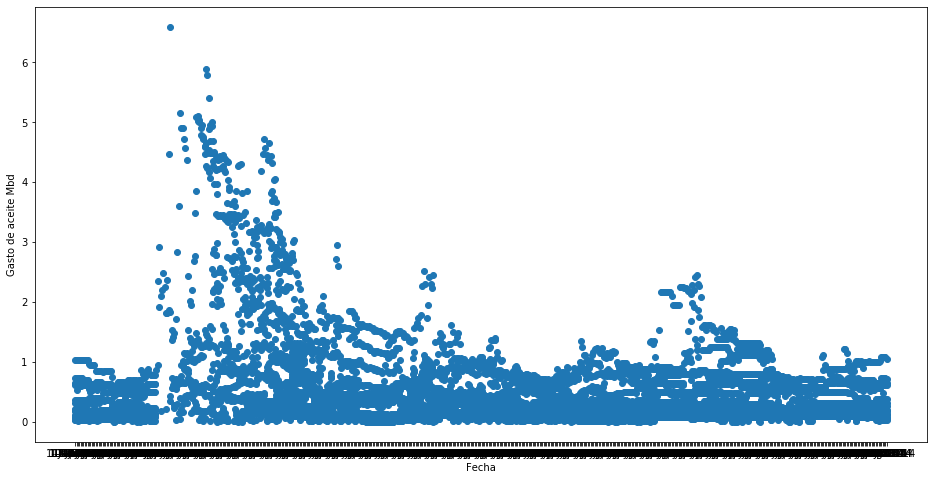

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


('lognorm', 5.292794053299753e-05)

115.14188581499911

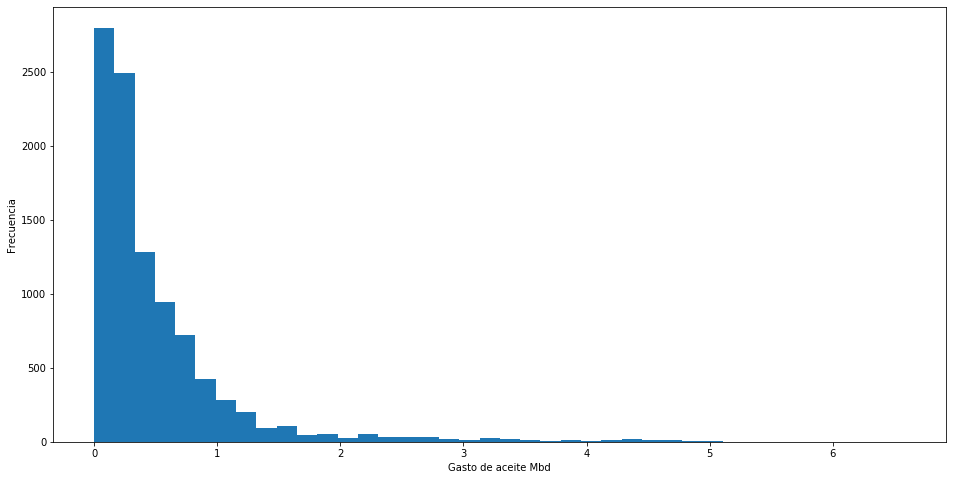

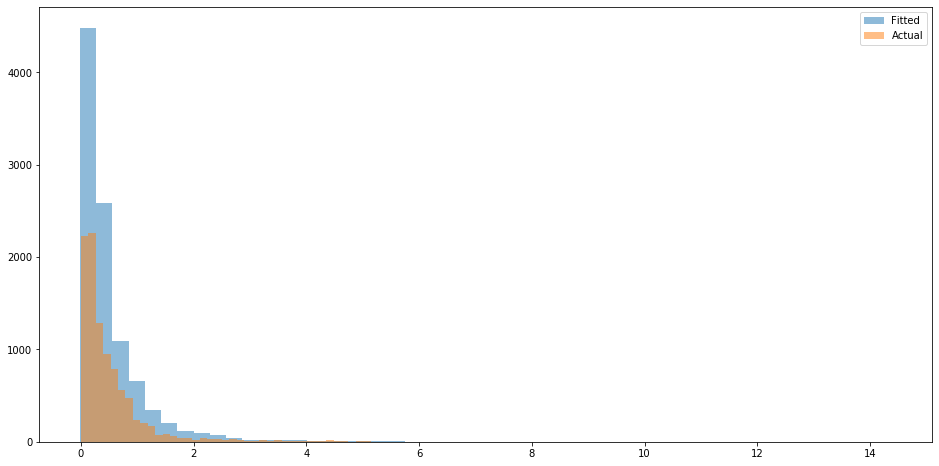

In [112]:
estadistica_campo()

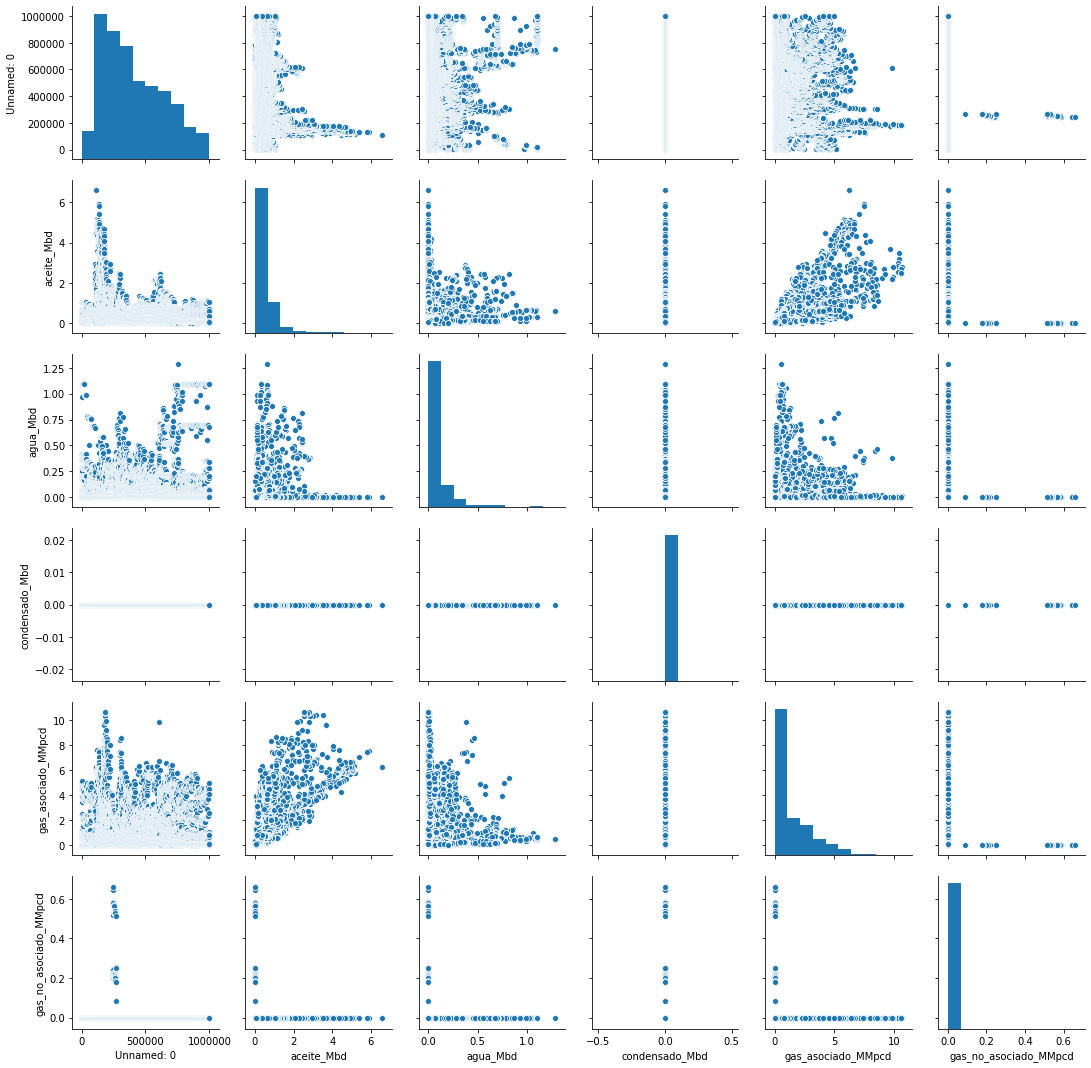

In [113]:
sns.pairplot(campo)

# DCA

Exponential Fit Curve-fitted Variables: qi=1.9291865000000001, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=3.043867903908122, b=1.9999999999989433, di=0.0014824899140135294
Harmonic Fit Curve-fitted Variables: qi=2.2802735326894608, b=2.2802735326894608, di=0.00037874754830158385


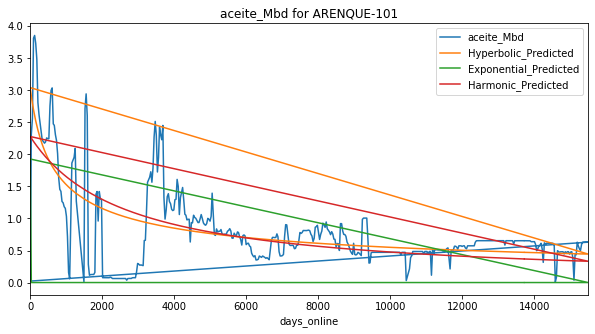

Exponential Fit Curve-fitted Variables: qi=0.092115, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.09549863106517811, b=1.9999966060640748, di=2.0763110217642975e-21
Harmonic Fit Curve-fitted Variables: qi=0.09549863276648748, b=0.09549863276648748, di=5.3548317673480926e-21


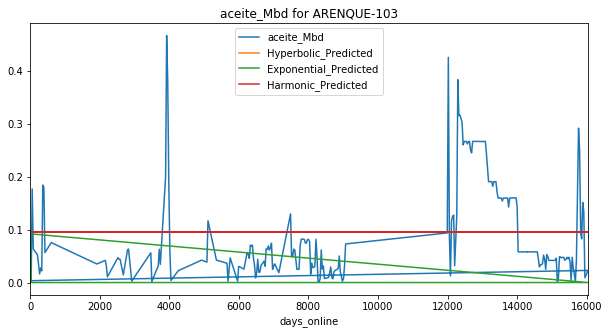

Exponential Fit Curve-fitted Variables: qi=0.7390515000000001, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=1.2229525894549054, b=1.8861319059704251, di=0.0007654461706569089
Harmonic Fit Curve-fitted Variables: qi=0.9940081968180261, b=0.9940081968180261, di=0.0002687863246633696


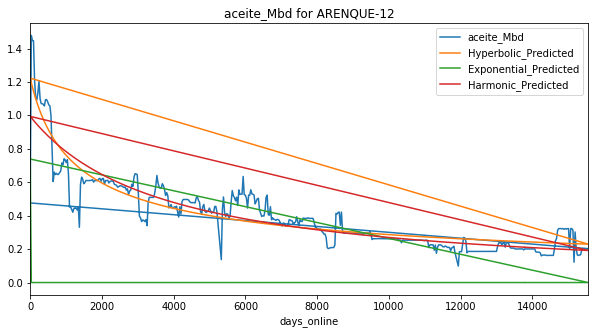

Exponential Fit Curve-fitted Variables: qi=2.5799025, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=4.7371352446133725, b=0.6309925139936138, di=0.0005617043496927565
Harmonic Fit Curve-fitted Variables: qi=4.838305455666739, b=4.838305455666739, di=0.0007449609769300362


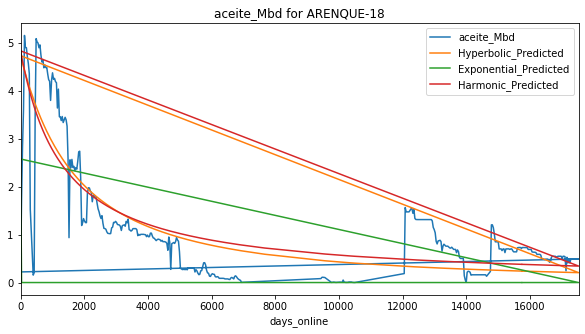

Exponential Fit Curve-fitted Variables: qi=0.20054, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.40107999999999994, b=1.9999999999999998, di=3.18849950558071e-17
Harmonic Fit Curve-fitted Variables: qi=0.40107999999999994, b=0.40107999999999994, di=1.586965129695681e-20


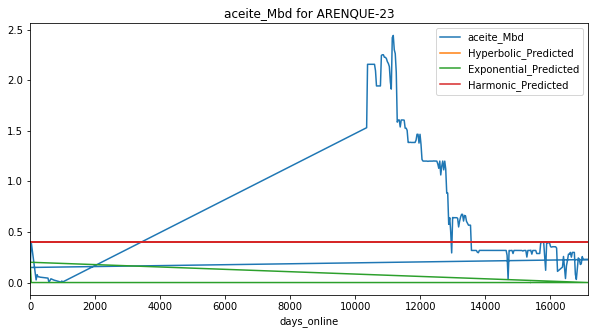

Exponential Fit Curve-fitted Variables: qi=1.0975700000000002, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=1.8851648302183581, b=1.6726239871011293, di=0.002235954260438207
Harmonic Fit Curve-fitted Variables: qi=1.4462053959301362, b=1.4462053959301362, di=0.0007082611102134529


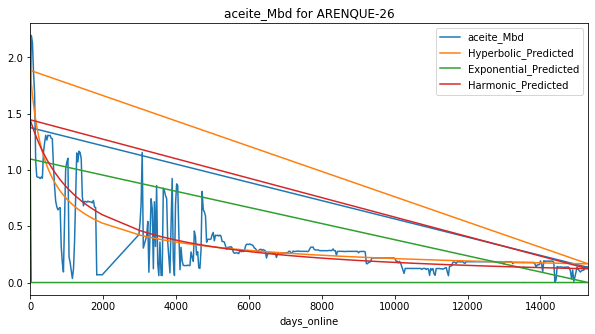

Exponential Fit Curve-fitted Variables: qi=2.4447405, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=1.7851424892107455, b=0.44210571135462395, di=0.00013449363357489683
Harmonic Fit Curve-fitted Variables: qi=1.8933858630007872, b=1.8933858630007872, di=0.00019772545514585218


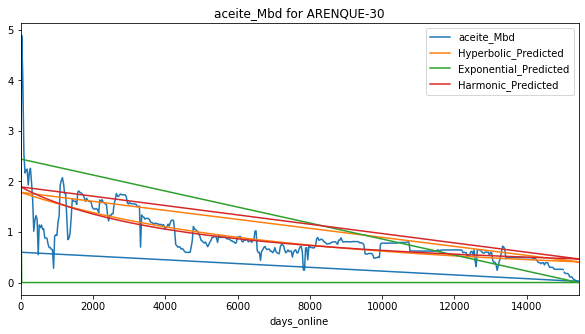

Exponential Fit Curve-fitted Variables: qi=0.0768255, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.15365097425997115, b=2.841214108731392e-06, di=7.71230048359429e-06
Harmonic Fit Curve-fitted Variables: qi=0.15045440413022348, b=0.15045440413022348, di=6.2730682247978585e-06


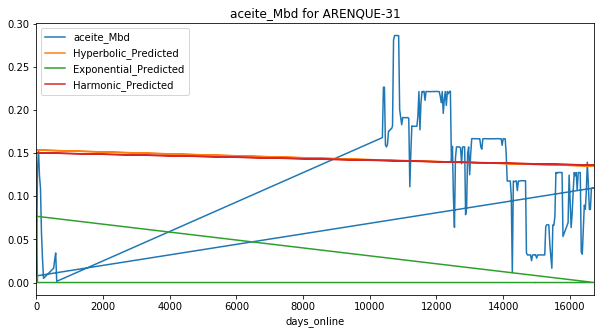

Exponential Fit Curve-fitted Variables: qi=0.0342895, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.06857899999999999, b=1.9999999999999998, di=5.543450976802931e-19
Harmonic Fit Curve-fitted Variables: qi=0.06857899999999999, b=0.06857899999999999, di=2.8706857579721298e-18


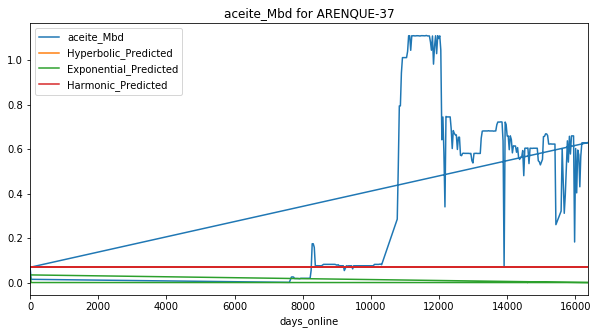

Exponential Fit Curve-fitted Variables: qi=0.7584310000000001, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=1.4090577272560947, b=0.6385101592539744, di=0.002076462695841794
Harmonic Fit Curve-fitted Variables: qi=1.5082747725066779, b=1.5082747725066779, di=0.0031366839483408715


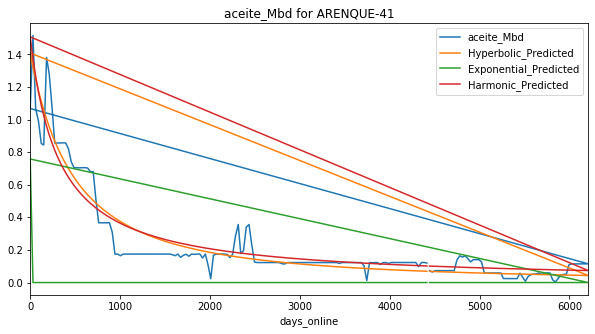

Exponential Fit Curve-fitted Variables: qi=1.4339695, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=2.213611724337263, b=1.9999999999999998, di=0.0013640822977156828
Harmonic Fit Curve-fitted Variables: qi=0.7816602676321337, b=0.7816602676321337, di=7.637411626790376e-07


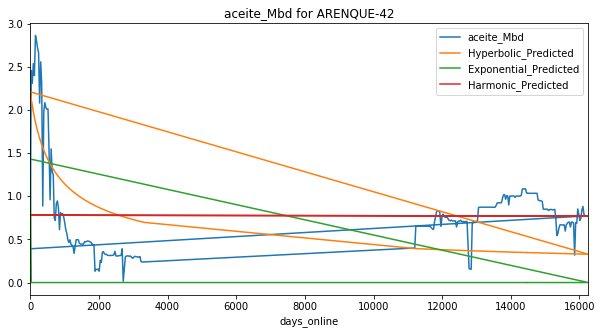

Exponential Fit Curve-fitted Variables: qi=0.4516075, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.29890024532277965, b=8.893425587435354e-12, di=6.064551439186706e-20
Harmonic Fit Curve-fitted Variables: qi=0.2989002445313039, b=0.2989002445313039, di=3.380035309703239e-16


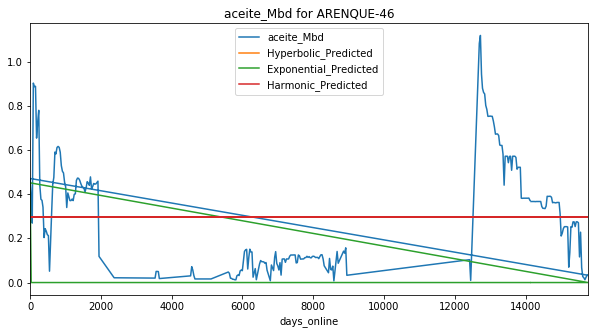

Exponential Fit Curve-fitted Variables: qi=0.14912899999999998, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.19901171005722623, b=0.5036305250335057, di=8.154398410485769e-05
Harmonic Fit Curve-fitted Variables: qi=0.20423699774556642, b=0.20423699774556642, di=0.00010241074640656958


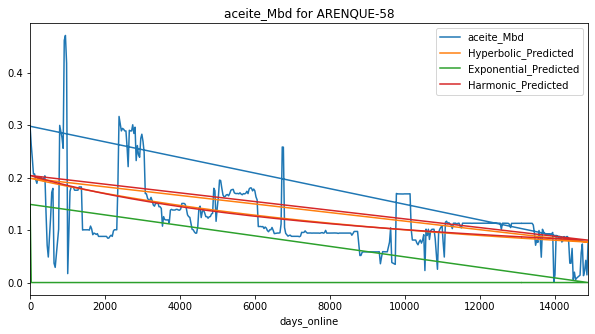

Exponential Fit Curve-fitted Variables: qi=1.239203, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=1.9962060398673045, b=0.9518080859311303, di=0.0013155880612535252
Harmonic Fit Curve-fitted Variables: qi=2.015400140819317, b=2.015400140819317, di=0.001395112240117909


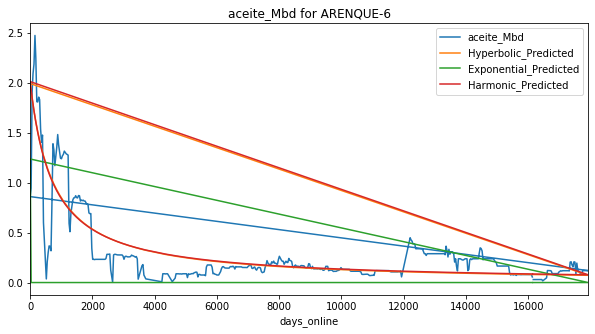

Exponential Fit Curve-fitted Variables: qi=2.949287, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=5.192324154852052, b=0.3177232655812162, di=0.0005616336160791915
Harmonic Fit Curve-fitted Variables: qi=5.805231542053951, b=5.805231542053951, di=0.001126985329524991


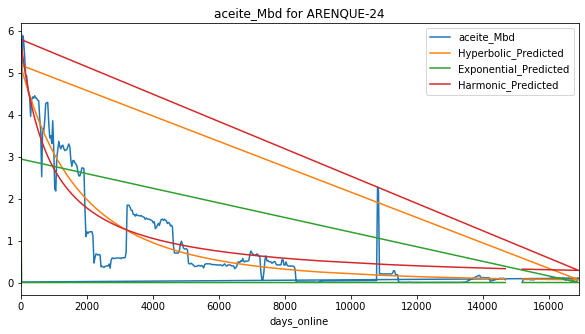

Exponential Fit Curve-fitted Variables: qi=2.358675, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=3.1755841419970308, b=1.7609655560237427, di=0.0011418811661585027
Harmonic Fit Curve-fitted Variables: qi=3.054557857447656, b=3.054557857447656, di=0.0006436609895206722


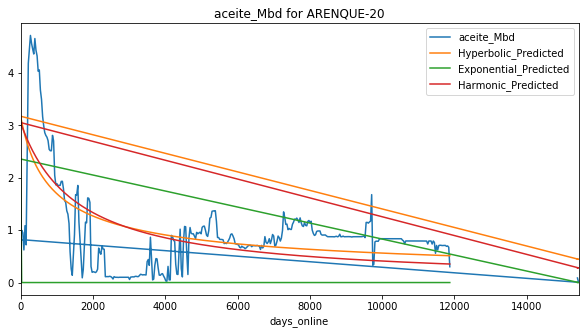

Exponential Fit Curve-fitted Variables: qi=0.649371, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=1.2987419999999972, b=1.9999999999999971, di=0.0025017038548691417
Harmonic Fit Curve-fitted Variables: qi=1.03045919221928, b=1.03045919221928, di=0.0007080813539935973


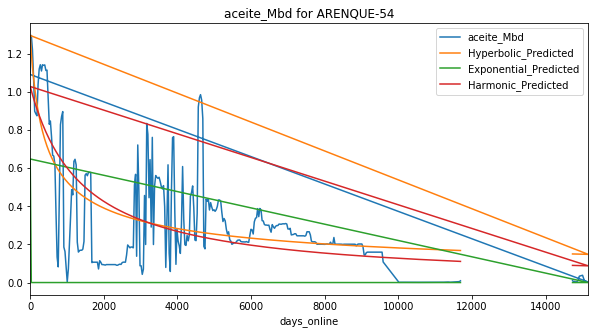

Exponential Fit Curve-fitted Variables: qi=3.2954495, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=2.73106586854819, b=0.876951927272855, di=0.003913986487916403
Harmonic Fit Curve-fitted Variables: qi=2.7731023986040175, b=2.7731023986040175, di=0.004532658490420488


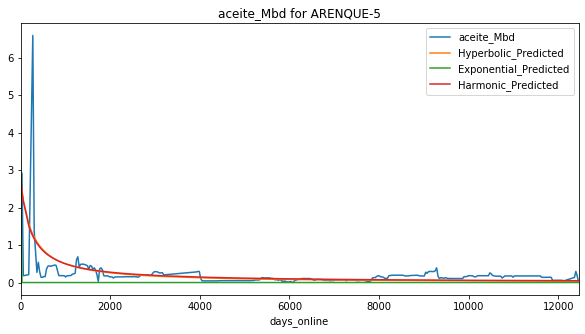

Exponential Fit Curve-fitted Variables: qi=0.47325649999999997, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.48765200203593495, b=1.9999999999999822, di=9.624136659898405e-16
Harmonic Fit Curve-fitted Variables: qi=0.48765199980285917, b=0.48765199980285917, di=2.2353988186273223e-17


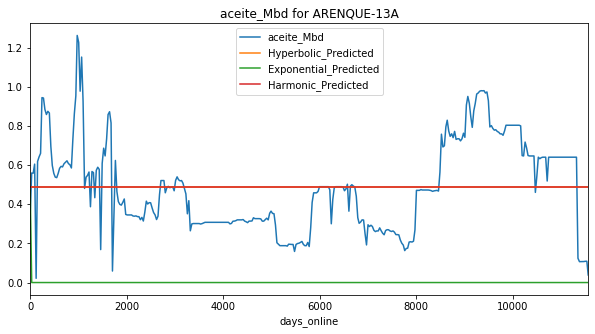

Exponential Fit Curve-fitted Variables: qi=0.36430100000000004, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.7061232946261109, b=5.285498984166452e-15, di=0.0004612443427143026
Harmonic Fit Curve-fitted Variables: qi=0.7286019999998435, b=0.7286019999998435, di=0.0007907527146590518


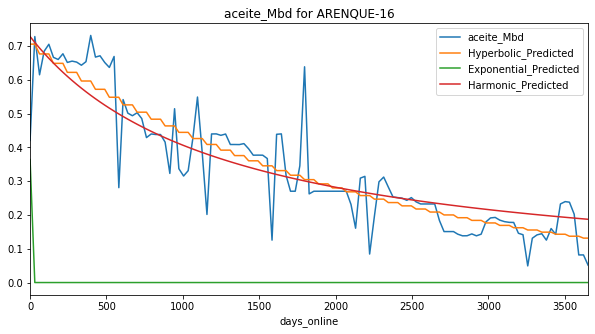

Exponential Fit Curve-fitted Variables: qi=0.5727774999999999, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=1.1455549999999997, b=0.6232040174471412, di=0.0002624738423677419
Harmonic Fit Curve-fitted Variables: qi=1.145554999999978, b=1.145554999999978, di=0.00031713374621268836


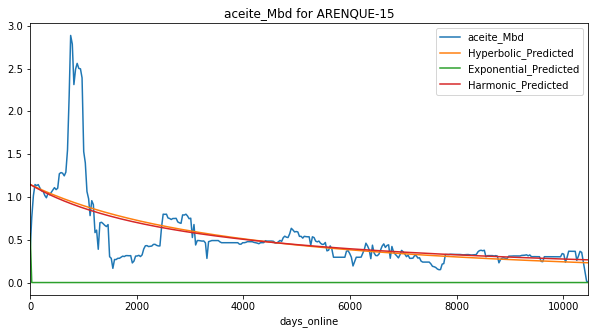

Exponential Fit Curve-fitted Variables: qi=2.5548759999999997, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=3.936755527956351, b=9.295009076475069e-10, di=0.00032699164816156565
Harmonic Fit Curve-fitted Variables: qi=3.9635538409231676, b=3.9635538409231676, di=0.00043619144622401536


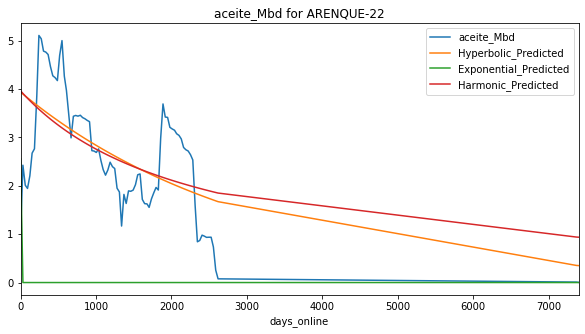

Exponential Fit Curve-fitted Variables: qi=1.409252, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=2.0129790643346683, b=1.3503265982736086, di=0.0010675971201460587
Harmonic Fit Curve-fitted Variables: qi=1.919217875115843, b=1.919217875115843, di=0.0007588720786999513


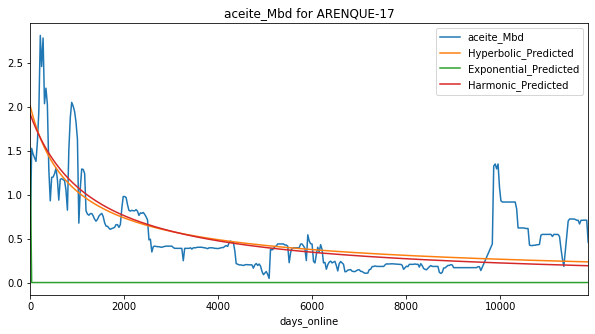

Exponential Fit Curve-fitted Variables: qi=0.16282449999999998, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.20248089036131198, b=1.089823495150812e-06, di=0.00032783262896819064
Harmonic Fit Curve-fitted Variables: qi=0.20339094960533724, b=0.20339094960533724, di=0.00045314511180964527


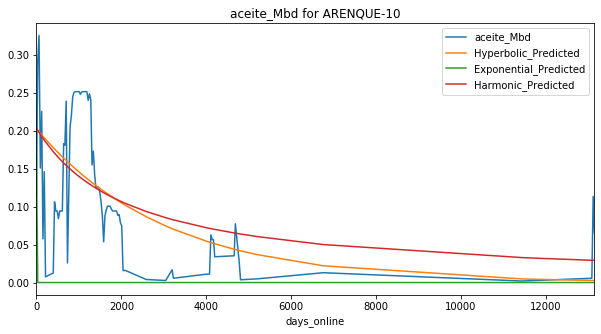

Exponential Fit Curve-fitted Variables: qi=1.93153, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=3.863059999999023, b=1.7275082510044233, di=0.0035071368847690724
Harmonic Fit Curve-fitted Variables: qi=3.4551629066082445, b=3.4551629066082445, di=0.0014791111677012621


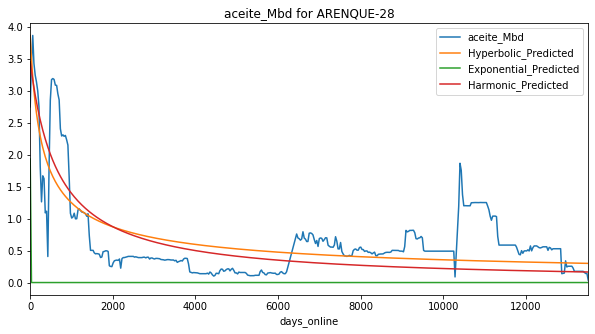

Exponential Fit Curve-fitted Variables: qi=0.231911, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.25161268158875, b=1.9999999999999998, di=0.0001234606706756507
Harmonic Fit Curve-fitted Variables: qi=0.2332484325473738, b=0.2332484325473738, di=7.09253268060794e-05


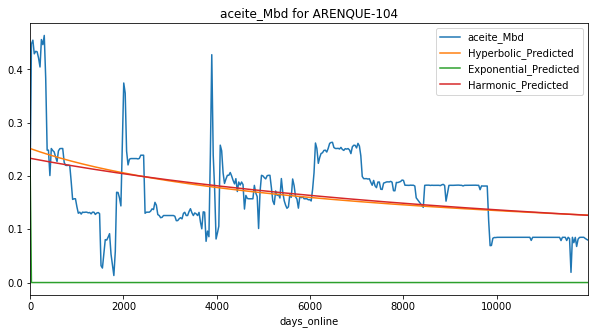

Exponential Fit Curve-fitted Variables: qi=0.3553735, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.4342844874329412, b=9.606830338001036e-09, di=0.0008706625965471627
Harmonic Fit Curve-fitted Variables: qi=0.4180951863966853, b=0.4180951863966853, di=0.0010475049166456928


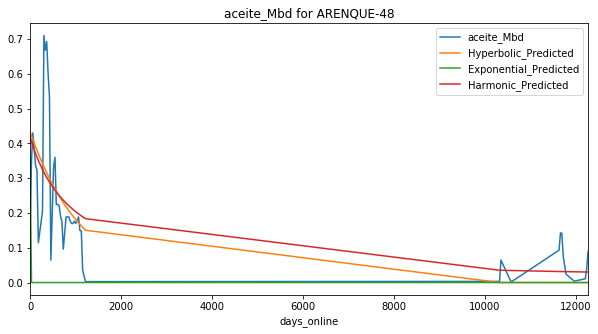

Exponential Fit Curve-fitted Variables: qi=1.57245, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=2.4532566817262174, b=1.1466231452844593, di=0.0013593060300985504
Harmonic Fit Curve-fitted Variables: qi=2.361338196759956, b=2.361338196759956, di=0.0010991641334990902


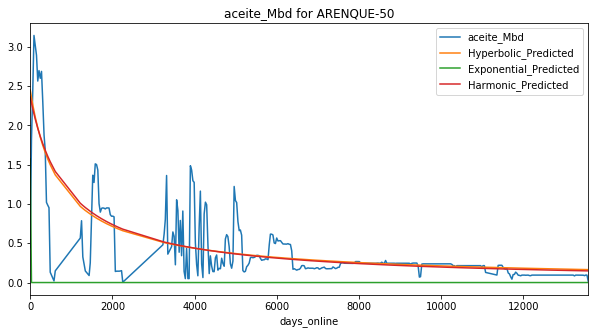

Exponential Fit Curve-fitted Variables: qi=0.06604299999999999, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.05993291928932893, b=1.9999992895870862, di=6.875152828333366e-17
Harmonic Fit Curve-fitted Variables: qi=0.05993291918260492, b=0.05993291918260492, di=1.3265976921006714e-17


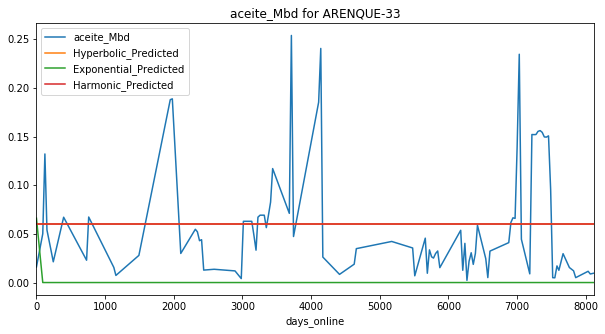

Exponential Fit Curve-fitted Variables: qi=0.631922, di=10.0
Hyperbolic Fit Curve-fitted Variables: qi=0.491405477031829, b=1.9999999999999998, di=0.0001846336176379485
Harmonic Fit Curve-fitted Variables: qi=0.38835236172610144, b=0.38835236172610144, di=5.1991852975023686e-05


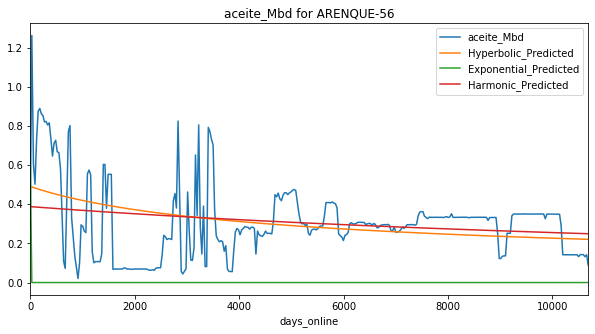

17.061138818000472

In [136]:
import timeit
tic=timeit.default_timer()

def read_in_csv(file_path):
    """
    Read in the specified csv as a pandas dataframe
    Arguments: 
        file_path: String. Path for the csv file that we want to read in
    Outputs:
        dataframe: Pandas dataframe.
    """
    well_data=pd.read_csv(file_path,parse_dates=True)
    return well_data

def remove_nan_and_zeroes_from_columns(df, variable):
    """
    This function cleans up a dataframe by removing rows in a specific 
    column that are null/NaN or equal to 0. This basically removes zero 
    production time periods.
    Arguments:
        df: Pandas dataframe.
        variable: String. Name of the column where we want to filter out
        NaN's or 0 values
    Output:
        filtered_df: Pandas dataframe. Dataframe with NaN's and zeroes filtered out of 
        the specified column
    """
    filtered_df = df[(df[variable].notnull()) & (df[variable]>0)]
    return filtered_df

def generate_time_delta_column(df, time_column, date_first_online_column):
    """
    Create column for the time that a well has been online at each reading, with 
    the first non-null month in the series listed as the start of production
    Arguments:
        df: Pandas dataframe
        time_column: String. Name of the column that includes the specific record date
        that the data was taken at. Column type is pandas datetime
        date_first_online_column: Name of the column that includes the date that the
        well came online. Column type is pandas datetime
    Outputs:
        Pandas series containing the difference in days between the date the well
        came online and the date that the data was recorded (cumulative days online)
    """
    df['Dias Produciendo']=(df[time_column]-df[date_first_online_column]).dt.days
    return (df[time_column]-df[date_first_online_column]).dt.days

def get_min_or_max_value_in_column_by_group(dataframe, group_by_column, calc_column, calc_type):
    global value
    """
    This function obtains the min or max value for a column, with a group by applied. For example,
    it could return the earliest (min) RecordDate for each API number in a dataframe 
    Arguments:
        dataframe: Pandas dataframe 
        group_by_column: string. Name of column that we want to apply a group by to
        calc_column: string. Name of the column that we want to get the aggregated max or min for
        calc_type: string; can be either 'min' or 'max'. Defined if we want to pull the min value 
        or the max value for the aggregated column
    Outputs:
        value: Depends on the calc_column type.
    """
    value=dataframe.groupby(group_by_column)[calc_column].transform(calc_type)
    return value

def get_max_initial_production(df, number_first_months, variable_column, date_column):
    global df_beginning_production
    """
    This function allows you to look at the first X months of production, and selects 
    the highest production month as max initial production
    Arguments:
        df: Pandas dataframe. 
        number_first_months: float. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        variable_column: String. Column name for the column where we're attempting to get
        the max volume from (can be either 'Gas' or 'Oil' in this script)
        date_column: String. Column name for the date that the data was taken at 
    """
    #First, sort the data frame from earliest to most recent prod date
    df=df.sort_values(by=date_column)
    #Pull out the first x months of production, where number_first_months is x
    df_beginning_production=df.head(number_first_months)
    #Return the max value in the selected variable column from the newly created 
    #df_beginning_production df
    return df_beginning_production[variable_column].max()

def hyperbolic_equation(t, qi, b, di):
    """
    Hyperbolic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        b: Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/((1.0+b*di*t)**(1.0/b))

def exponential_equation(t, qi, di):
    """
    Exponential decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi*np.exp(-di*t)

def harmonic_equation (t, qi, di):
    """
    Harmonic decline curve equation
    Arguments:
        t: Float. Time since the well first came online, can be in various units 
        (days, months, etc) so long as they are consistent.
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
    Output: 
        Returns q, or the expected production rate at time t. Float.
    """
    return qi/(1+(di*t))

def plot_actual_vs_predicted_by_equations(df, x_variable, y_variables, plot_title):
    """
    This function is used to map x- and y-variables against each other
    Arguments:
        df: Pandas dataframe.
        x_variable: String. Name of the column that we want to set as the 
        x-variable in the plot
        y_variables: string (single), or list of strings (multiple). Name(s) 
        of the column(s) that we want to set as the y-variable in the plot
    """
    #Plot results
    df.plot(x=x_variable, y=y_variables, title=plot_title,figsize=(10,5))
    plt.show()

def main(file_path):
    global well_data
    global results
    results=pd.DataFrame()
    #Read in the monthly oil and gas data
    #file_path=r'/Users/fffte/Documents/GitHub/Ainda/Proyecto Newton/02_productividad/kumaza_produccion.csv'
    well_data=read_in_csv(file_path)
    #Perform some data cleaning to get the columns as the right data type
    well_data['fecha']=pd.to_datetime(well_data['fecha'])
    #Declare the desired product that we want to curve fit for--it can either by 'Gas' or 'Oil'
    hydrocarbon='aceite_Mbd'
    #Remove all rows with null values in the desired time series column
    well_data=remove_nan_and_zeroes_from_columns(well_data, hydrocarbon)
    #Get a list of unique wells to loop through
    unique_well_list=pd.unique(list(well_data.pozo))
    #Get the earliest RecordDate for each Well
    well_data['first_oil']= get_min_or_max_value_in_column_by_group(well_data, group_by_column='pozo', 
                  calc_column='fecha', calc_type='min')
    #Generate column for time online delta
    well_data['days_online']=generate_time_delta_column(well_data, time_column='fecha', 
                  date_first_online_column='first_oil')
    #Pull data that came online between an specified range
    well_data_range=well_data[(well_data.fecha>='1900-01-01') & (well_data.fecha<='2019-12-01')]
    #Loop through each well, and perform calculations
    for pozo in unique_well_list:
        #Subset the dataframe by Well
        production_time_series=well_data_range[well_data_range.pozo==pozo]
        #Get the highest value of production in the first X months of production, to use as qi value
        qi=get_max_initial_production(production_time_series, 12, hydrocarbon, 'fecha')
        #Exponential curve fit the data to get best fit equation
        popt_exp, pcov_exp=curve_fit(exponential_equation, production_time_series['days_online']+12, 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,20]))
        print('Exponential Fit Curve-fitted Variables: qi='+str(popt_exp[0])+', di='+str(popt_exp[1]))
        #Hyperbolic curve fit the data to get best fit equation
        popt_hyp, pcov_hyp=curve_fit(hyperbolic_equation, production_time_series['days_online']+12, 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,2,20]))
        print('Hyperbolic Fit Curve-fitted Variables: qi='+str(popt_hyp[0])+', b='+str(popt_hyp[1])+', di='+str(popt_hyp[2]))
        #Harmonic curve fit the data to get best fit equation
        popt_harm, pcov_harm=curve_fit(harmonic_equation, production_time_series['days_online']+12, 
                                     production_time_series[hydrocarbon],bounds=(0, [qi,20]))
        print('Harmonic Fit Curve-fitted Variables: qi='+str(popt_harm[0])+', b='+str(popt_harm[0])+', di='+str(popt_harm[1]))
        #Exponential fit results
        production_time_series.loc[:,'Exponential_Predicted']=exponential_equation(production_time_series['days_online'], 
                                  *popt_exp)
        #Hyperbolic fit results
        production_time_series.loc[:,'Hyperbolic_Predicted']=hyperbolic_equation(production_time_series['days_online'], 
                                  *popt_hyp)
        #Harmonic fit results
        production_time_series.loc[:,'Harmonic_Predicted']=harmonic_equation(production_time_series['days_online'], 
                                  *popt_harm)
        
        #Declare the x- and y- variables that we want to plot against each other
        y_variables=[hydrocarbon,"Hyperbolic_Predicted", "Exponential_Predicted", "Harmonic_Predicted"]
        x_variable='days_online'
        #Create the plot title
        plot_title=hydrocarbon+' for '+str(pozo)
        #Plot the data to visualize the equation fit
        plot_actual_vs_predicted_by_equations(production_time_series, x_variable, y_variables, plot_title)
        
        results=results.append(production_time_series)
    
    results.to_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/'+str(input_campo)+'_dca.csv')
    
if __name__== "__main__":
    main(r'/Users/fffte/ainda_drive/python/csv/benchmark/ARENQUE.csv')

toc=timeit.default_timer()
toc - tic #elapsed time in seconds

In [120]:
df=pd.read_csv(r'/Users/fffte/ainda_drive/python/csv/benchmark/ARENQUE_dca.csv')

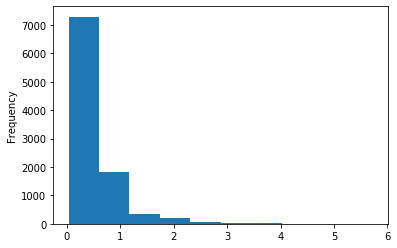

In [121]:
df.Harmonic_Predicted.plot.hist()

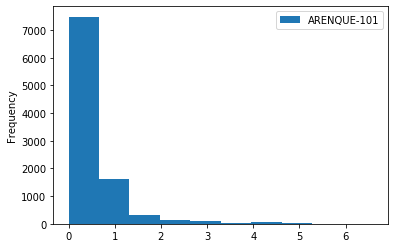

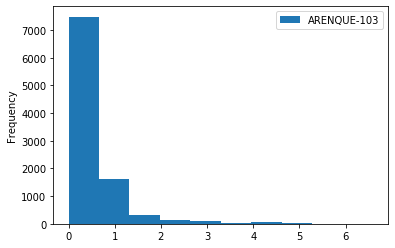

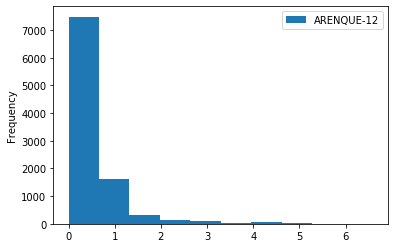

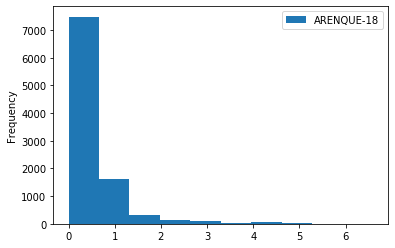

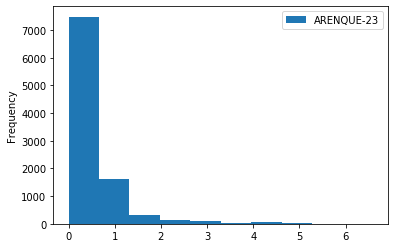

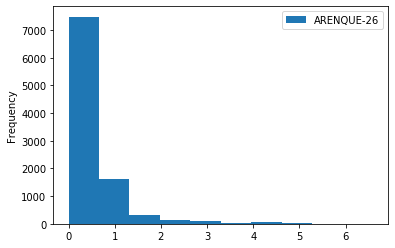

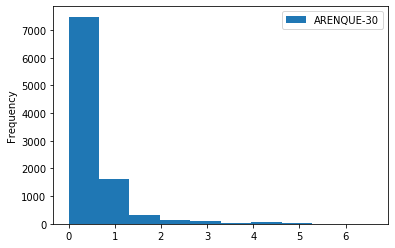

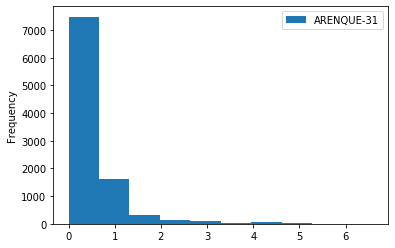

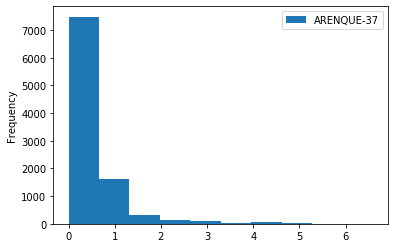

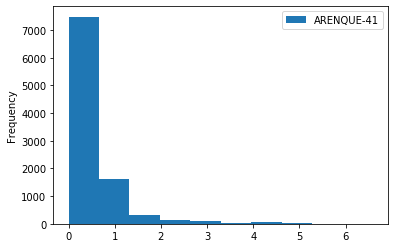

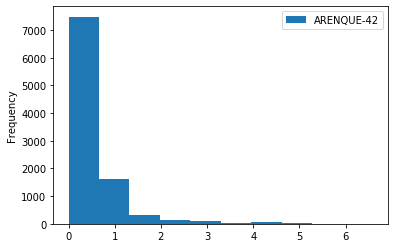

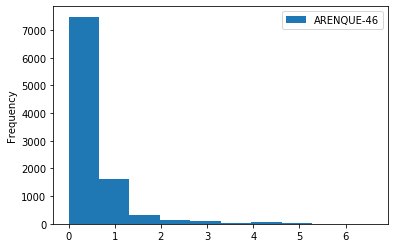

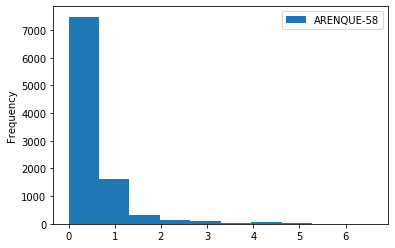

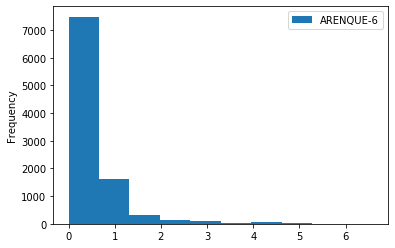

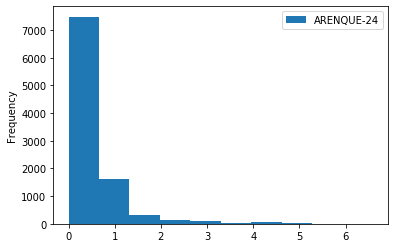

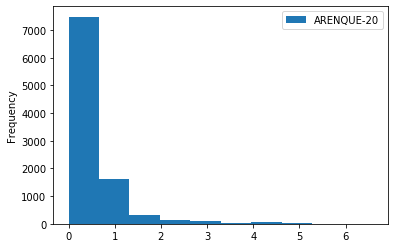

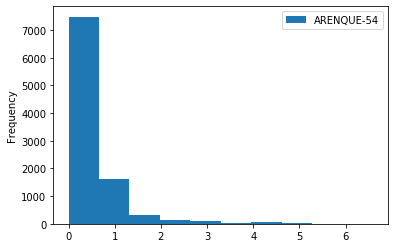

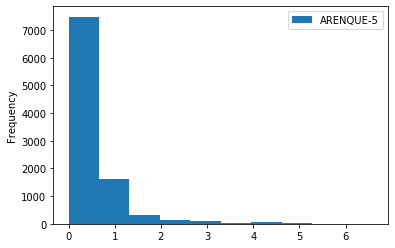

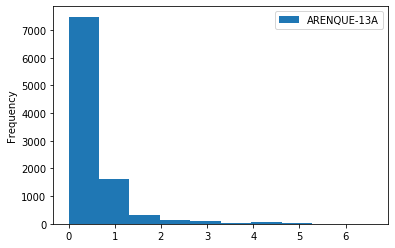

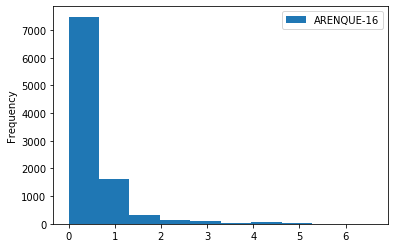

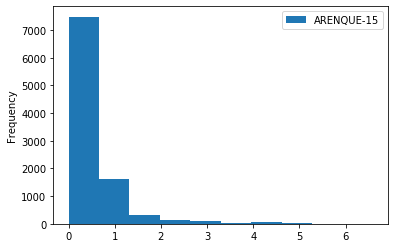

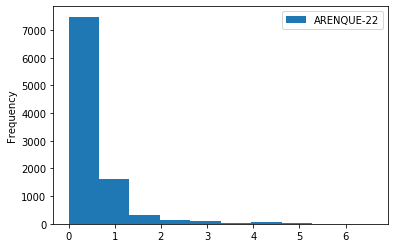

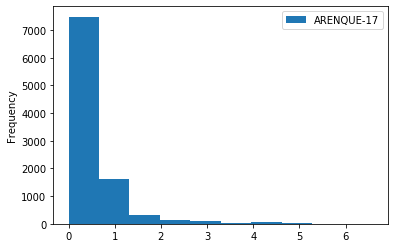

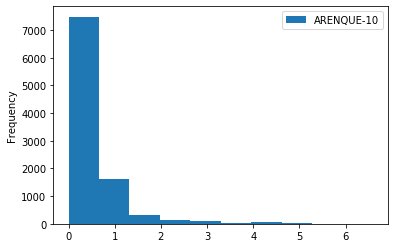

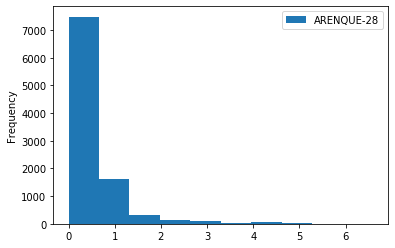

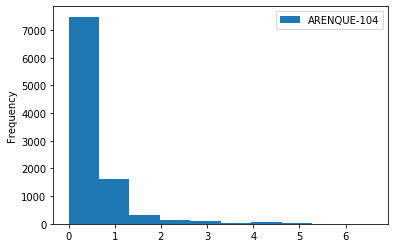

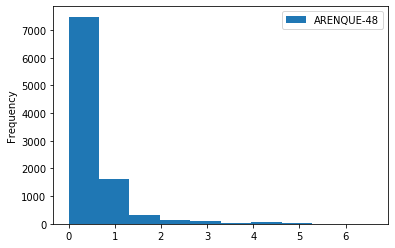

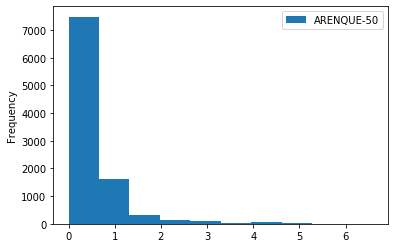

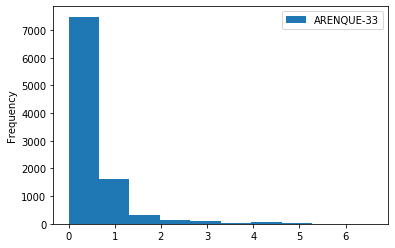

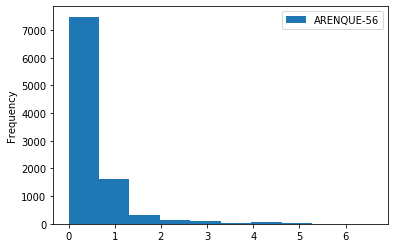

In [130]:
unique_well_list=pd.unique(list(df.pozo))

for x in unique_well_list:
        df2=pd.DataFrame()
        df2[x]=df.aceite_Mbd
        display(df2.plot.hist())     